In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
from parameters import *
from static import *
from data_frame import *

In [4]:
parameters

NameError: name 'parameters' is not defined

In [177]:
data = data_frame('../data/GSPC.csv', reference_date, current_date, moveback_date)
data.reference_date
data.df.tail()

NameError: name 'data_frame' is not defined

# Data Visualization

### Baseline

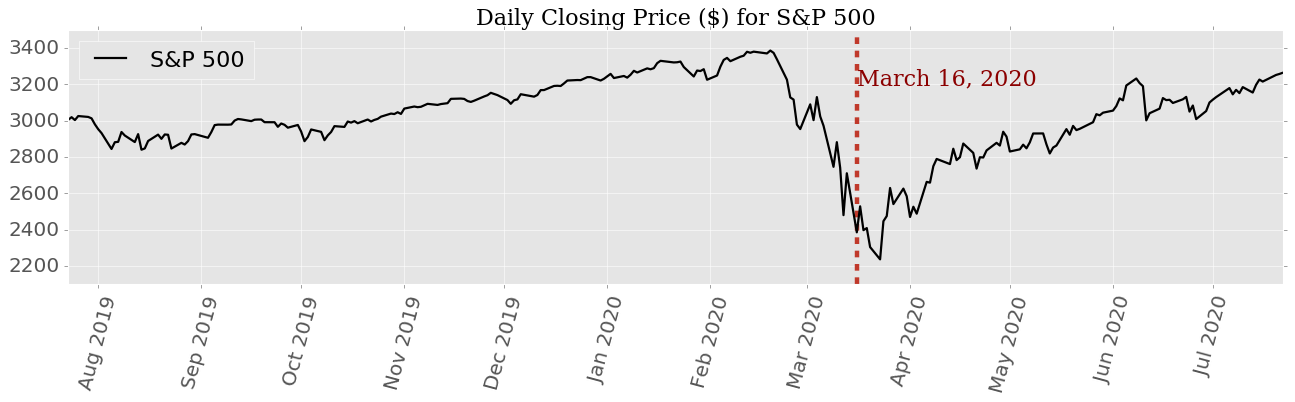

In [156]:
fig, ax = plt.subplots(figsize=(16, 4))
data = data_assessment('../data/GSPC.csv', reference_date, current_date, moveback_date)
ax.plot(data.df.index, data.df['Close'], color='k', label='S&P 500', linewidth=2)
ax.legend(loc='best', prop={'size': 20});
ax.set_title('Daily Closing Price ($) for S&P 500', fontdict=font, color='k');
ax.vlines(data.reference_date, 2100, 3500, colors='#C0392B', linestyles='dashed', linewidth=4)
fig.tight_layout()
ax.xaxis.set_tick_params(rotation=75)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.text(data.reference_date, 3200, r'March 16, 2020', fontdict=font);
ax.set_ylim(2100, 3500)
plt.savefig('../figures/baseline.png')

### Test Date

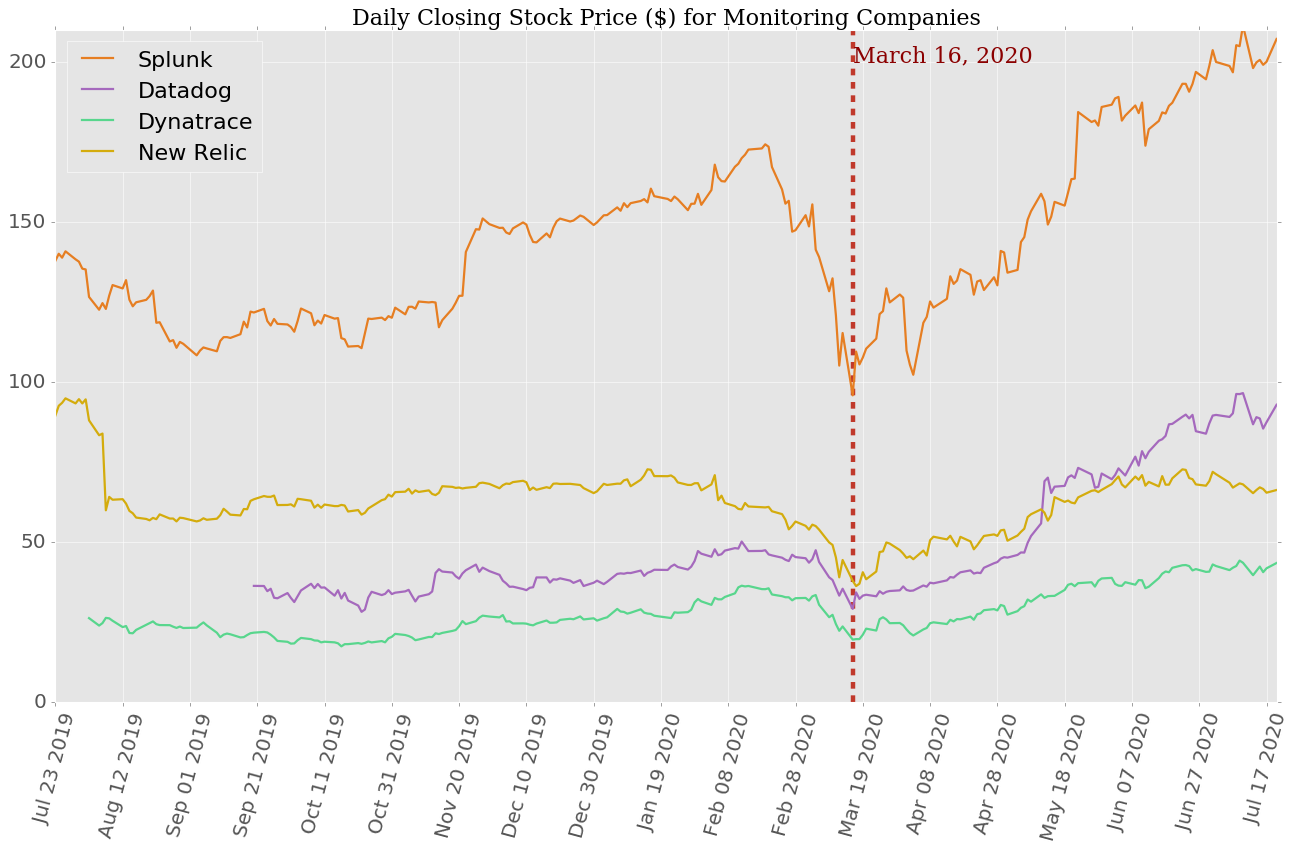

In [157]:
fig, ax = plt.subplots(figsize=(16, 10))

for filepath,color in zip(filepaths, colors):
    data = data_assessment(filepath, reference_date, current_date, moveback_date)
    ax.plot(data.df.index, data.df['Close'], color=color, label=refer[filepath], linewidth=2)

ax.vlines(data.reference_date, 0, 210, colors='#C0392B', linestyles='dashed', linewidth=4)
ax.legend(loc='best', prop={'size': 20});
ax.set_title('Daily Closing Stock Price ($) for Monitoring Companies', fontdict=font, color='k');
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 20));
ax.xaxis.set_tick_params(rotation=75)
fig.tight_layout()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.text(data.reference_date, 200, r'March 16, 2020', fontdict=font);
ax.set_ylim(0, 210)
plt.savefig('../figures/comparison.png')

# Test Statistics
* Take difference shift(-1)
* Take 120 difference points after covid and 120 before covid
* Compute {mean, stardard deviation} of the before and after data
* Plot normal curves and run a p test

In [158]:
filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
before_after_dict = dict()
statistics = dict()

for filepath in filepaths:
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after

    before_after_dict[refer[filepath]] = {'before': before['Diff'],'after': after['Diff']}
    statistics[refer[filepath]] = {'before': {'mean': round(before['Diff'].mean(),3), 'std': round(before['Diff'].std(), 3)},
                                                'after': {'mean': round(after['Diff'].mean(), 3), 'std': round(after['Diff'].std(), 3)}} 

In [159]:
pd.DataFrame(statistics)

,Splunk,Datadog,Dynatrace,New Relic
before,"{'mean': -0.228, 'std': 4.612}","{'mean': -0.039, 'std': 1.699}","{'mean': 0.008, 'std': 1.101}","{'mean': -0.222, 'std': 1.781}"
after,"{'mean': 1.28, 'std': 5.582}","{'mean': 0.733, 'std': 2.727}","{'mean': 0.275, 'std': 1.263}","{'mean': 0.326, 'std': 1.983}"


In [160]:
statistics['Splunk']['before']['mean']

-0.228

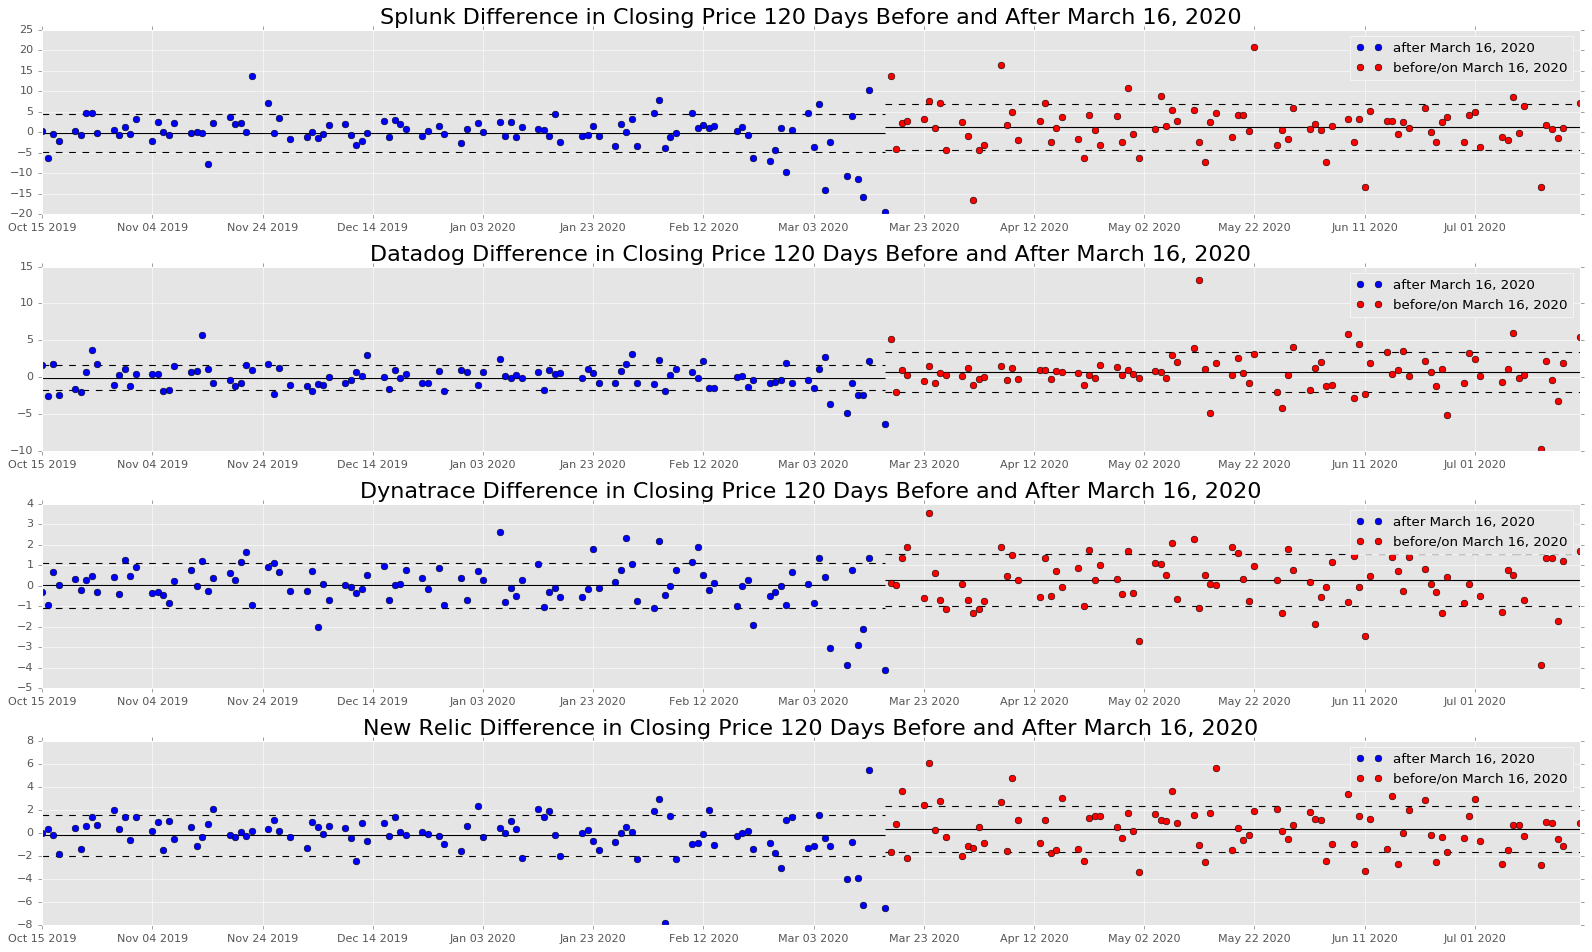

In [161]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12))

filepaths = list(['../data/SPLK.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/NEWR.csv'])
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    ax.plot(before.index, before["Diff"], 'o', color='b', label='after March 16, 2020')
    ax.hlines(statistics[refer[filepath]]['before']['mean'], data.moveback_date, data.reference_date, colors='k', linestyles='solid')
    ax.hlines(statistics[refer[filepath]]['before']['mean'] + statistics[refer[filepath]]['before']['std'], data.moveback_date, data.reference_date, colors='k', linestyles='dashed')
    ax.hlines(statistics[refer[filepath]]['before']['mean'] - statistics[refer[filepath]]['before']['std'], data.moveback_date, data.reference_date, colors='k', linestyles='dashed')
    ax.plot(after.index, after["Diff"], 'o', color='r', label='before/on March 16, 2020')
    ax.hlines(statistics[refer[filepath]]['after']['mean'], data.reference_date, data.current_date, colors='k', linestyles='solid')
    ax.hlines(statistics[refer[filepath]]['after']['mean'] + statistics[refer[filepath]]['after']['std'], data.reference_date, data.current_date, colors='k', linestyles='dashed')
    ax.hlines(statistics[refer[filepath]]['after']['mean'] - statistics[refer[filepath]]['after']['std'], data.reference_date, data.current_date, colors='k', linestyles='dashed')
#     ax.vlines(data.reference_date, np.min(data.df['Diff'])-1, np.max(data.df['Diff'])+1, colors='#C0392B', linestyles='dashed', linewidth=4)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 20));
    ax.set_title(refer[filepath] + ' Difference in Closing Price 120 Days Before and After March 16, 2020', fontsize=20);
    ax.legend()
    
fig.tight_layout();
plt.savefig('../figures/before_after_diff_distribution.png')

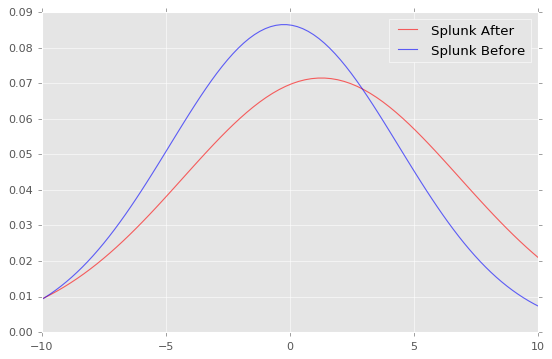

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

x = np.linspace(stats.norm.ppf(0.01, statistics['Splunk']['after']['mean'], statistics['Splunk']['after']['std']), stats.norm.ppf(0.99, statistics['Splunk']['after']['mean'], statistics['Splunk']['after']['std']), 100)
ax.plot(x, stats.norm.pdf(x, statistics['Splunk']['after']['mean'],  statistics['Splunk']['after']['std']), 'r-', lw=1, alpha=0.6, label='Splunk After')
x = np.linspace(stats.norm.ppf(0.01, statistics['Splunk']['before']['mean'], statistics['Splunk']['before']['std']), stats.norm.ppf(0.99, statistics['Splunk']['before']['mean'], statistics['Splunk']['before']['std']), 100)
ax.plot(x, stats.norm.pdf(x, statistics['Splunk']['before']['mean'],  statistics['Splunk']['before']['std']), 'b-', lw=1, alpha=0.6, label='Splunk Before')
ax.set_xlim((-10, 10))
ax.legend()

## Plot distributions before and after March 16, 2020

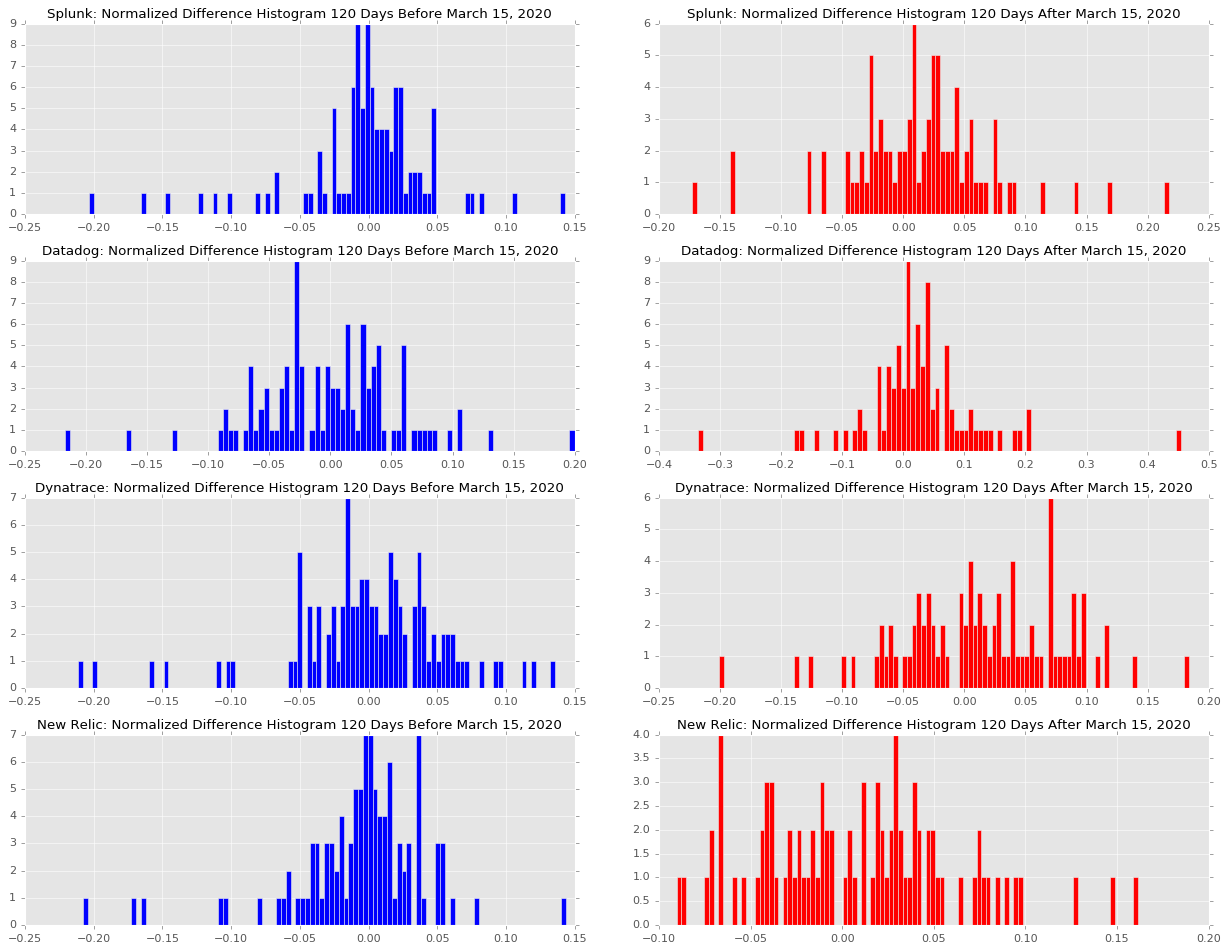

In [173]:
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
plots = axs.flatten()

filepaths = list(['../data/SPLK.csv', '../data/SPLK.csv', '../data/DDOG.csv', '../data/DDOG.csv', '../data/DT.csv', '../data/DT.csv', '../data/NEWR.csv', '../data/NEWR.csv'])
    
for filepath, ax, c  in zip(filepaths, axs.flatten(), np.arange(8)):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before, data.after
    if c % 2:
        ax.hist(after["Normalized_Diff"], bins=100, color='r')
        ax.set_title(refer[filepath] + ': Normalized Difference Histogram 120 Days After March 15, 2020', fontsize=12)
    else:
        ax.hist(before["Normalized_Diff"], bins=100, color='b')
        ax.set_title(refer[filepath] + ': Normalized Difference Histogram 120 Days Before March 15, 2020', fontsize=12)
        
fig.tight_layout();
plt.savefig('../figures/before_after_Histogram_Normalized_Diff.png')

## T-test on before and after data

In [172]:
hyp_test = dict()
for filepath, ax  in zip(filepaths, axs):
    data = data_assessment(filepath, reference_date, current_date, moveback_date).before_after
    before, after = data.before['Diff'], data.after['Diff']
    stat, p_val = stats.ttest_ind(before, after, axis=0, equal_var=False, nan_policy='omit')
    
    hyp_test[refer[filepath]] = {'t_stat': stat, 'p_val': p_val}

pd.DataFrame(hyp_test)

,Splunk,Datadog,Dynatrace,New Relic
t_stat,-2.014599,-2.298923,-1.544077,-1.998822
p_val,0.045554,0.023007,0.124407,0.047177
